# LLM Factor Analysis - Personality Items (Qwen3-Embedding-4B)

Extracts embeddings from NEO personality items using **Qwen3-Embedding-4B** (4B parameter model) with FP16 precision and compares predicted similarities with observed correlations.

**Model Details:**
- Model: Qwen3-Embedding-4B (4 billion parameters)
- Precision: FP16 (half-precision for memory efficiency)
- Library: sentence-transformers (simplified API)
- Supports: 100+ languages, MTEB top-ranked performance

## Setup and Data Validation

In [1]:
import os
import sys

print("Starting Qwen3 Factor Analysis...")

# Check for required data files
required_files = ['Big5_items.csv']
missing_files = [f for f in required_files if not os.path.exists(f)]
if missing_files:
    print(f"Error: Missing required data files: {', '.join(missing_files)}")
    print("Please ensure these files are in the current working directory.")
else:
    print("✓ Data files found. Loading dependencies (this may take a moment)...")

Starting Qwen3 Factor Analysis...
✓ Data files found. Loading dependencies (this may take a moment)...


## Import Dependencies

This notebook requires:
- `sentence-transformers>=2.7.0`
- `transformers>=4.51.0`
- `torch>=2.0.0` with MPS support for Apple Silicon

In [2]:
import pandas as pd
import numpy as np
print("  - pandas and numpy loaded")

import torch
print(f"  - torch {torch.__version__} loaded")

# Check if sentence-transformers is installed
try:
    from sentence_transformers import SentenceTransformer
    import sentence_transformers
    print(f"  - sentence-transformers {sentence_transformers.__version__} loaded")
except ImportError:
    print("\n⚠️  ERROR: sentence-transformers not found!")
    print("Please install: pip install sentence-transformers>=2.7.0")
    raise

# Check transformers version
import transformers
print(f"  - transformers {transformers.__version__} loaded")

  - pandas and numpy loaded
  - torch 2.7.1 loaded


/localscratch/devon7y.8125960.0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  - sentence-transformers 5.1.1 loaded
  - transformers 4.57.1 loaded


## Load and Process Data

In [3]:
print("Loading NEO personality items...")
neo_items = pd.read_csv('Big5_items.csv', usecols=['item', 'factor'])
print(f"Loaded {len(neo_items)} items")

# Preview the data
neo_items.head()

Loading NEO personality items...
Loaded 50 items


,item,factor
0,I am the life of the party.,Extraversion
1,I don't talk a lot.,Extraversion
2,I feel comfortable around people.,Extraversion
3,I keep in the background.,Extraversion
4,I start conversations.,Extraversion


In [4]:
# Extract items and factors for easier access
items = neo_items['item'].tolist()
factors = neo_items['factor'].tolist()

print(f"Total items: {len(items)}")
print(f"Unique factors: {sorted(set(factors))}")

Total items: 50
Unique factors: ['Agreeableness', 'Conscientiousness', 'Extraversion', 'Neuroticism', 'Openness']


## Device Detection and Memory Check

In [5]:
# Detect available device
print("Detecting available device...")
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✓ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("✓ Using Apple MPS GPU (Metal Performance Shaders)")
else:
    device = torch.device('cpu')
    print("✓ Using CPU")

# Check available memory (basic check)
try:
    import psutil
    mem = psutil.virtual_memory()
    print(f"\nSystem Memory:")
    print(f"  Total: {mem.total / (1024**3):.1f} GB")
    print(f"  Available: {mem.available / (1024**3):.1f} GB")
    print(f"  Used: {mem.percent}%")
except ImportError:
    print("\n⚠️  psutil not installed - skipping memory check")
    print("Install with: pip install psutil")

Detecting available device...
✓ Using CUDA GPU: NVIDIA H100 80GB HBM3 MIG 2g.20gb

System Memory:
  Total: 1133.6 GB
  Available: 1091.9 GB
  Used: 3.7%


## Load Qwen3-Embedding-4B Model

**Memory Requirements:**
- FP32 (full precision): ~16 GB
- FP16 (half precision): ~8 GB ⬅️ Using this
- INT8 (quantized): ~4 GB

We're using FP16 to balance quality and memory usage. On a 16GB M1 Pro, this should work but will be tight.

**Note:** If you encounter out-of-memory errors, reduce `batch_size` in the encoding step below.

In [6]:
print("Loading Qwen3-Embedding-4B model with FP16 precision...")
print("This may take 30-60 seconds and download ~8GB if not cached.")
print()

try:
    # Load model with FP16 for memory efficiency
    model = SentenceTransformer(
        "Qwen/Qwen3-Embedding-8B",
        model_kwargs={
            "dtype": torch.float16,  # FP16 precision (~8GB)
            "device_map": "auto",  # Automatically map to MPS/CUDA/CPU
        },
        # For Qwen models, padding_side="left" is recommended but may cause issues on MPS
        # Leaving default for now
    )
    
    print(f"✓ Model loaded successfully!")
    print(f"  Device: {model.device}")
    print(f"  Max sequence length: {model.max_seq_length}")
    
    # Check embedding dimension
    test_embedding = model.encode(["test"], convert_to_numpy=True)
    print(f"  Embedding dimension: {test_embedding.shape[1]}")
    
except Exception as e:
    print(f"\n⚠️  Error loading model with FP16 on {device}:")
    print(f"  {str(e)}")
    print("\nTrying fallback: CPU with FP32...")
    
    # Fallback to CPU with full precision
    model = SentenceTransformer(
        "Qwen/Qwen3-Embedding-4B",
        device="cpu"
    )
    print("✓ Model loaded on CPU (slower but will work)")

Loading Qwen3-Embedding-4B model with FP16 precision...
This may take 30-60 seconds and download ~8GB if not cached.



Loading checkpoint shards: 100%|██████████| 4/4 [00:13<00:00,  3.40s/it]


✓ Model loaded successfully!
  Device: cuda:0
  Max sequence length: 40960
  Embedding dimension: 4096


## Extract Embeddings

Using sentence-transformers' `encode()` method - much simpler than manual tokenization!

**Memory Safety:**
- Starting with `batch_size=4` (conservative)
- If you get OOM errors, reduce to `batch_size=2` or `batch_size=1`
- If it works fine, you can increase to `batch_size=8` for faster processing

In [7]:
print(f"Extracting embeddings for {len(items)} personality items...")
print("This may take 1-3 minutes depending on your hardware.\n")

try:
    # Extract embeddings - that's it! No manual tokenization needed.
    embeddings = model.encode(
        items,
        batch_size=4,  # Conservative batch size for memory safety
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=False  # Keep raw embeddings for analysis
    )
    
    print(f"\n✓ Embedding extraction complete!")
    print(f"  Shape: {embeddings.shape}")
    print(f"  (300 items × {embeddings.shape[1]} dimensions)")
    
except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print(f"\n⚠️  Out of memory error!")
        print(f"\nPlease try again with batch_size=2 or batch_size=1")
        print(f"Or switch to CPU by restarting and setting device='cpu'")
        raise
    else:
        raise

Extracting embeddings for 50 personality items...
This may take 1-3 minutes depending on your hardware.



Batches: 100%|██████████| 13/13 [00:00<00:00, 28.93it/s]


✓ Embedding extraction complete!
  Shape: (50, 4096)
  (300 items × 4096 dimensions)


## Inspect Results

In [8]:
# Check embedding dimensions
print(f"Embedding shape: {embeddings.shape}")
print(f"Embedding dimension: {embeddings.shape[1]} (vs DistilBERT's 768)")
print(f"\nFirst embedding vector (first 10 values):")
print(embeddings[0][:10])

Embedding shape: (50, 4096)
Embedding dimension: 4096 (vs DistilBERT's 768)

First embedding vector (first 10 values):
[ 0.0361    0.00797   0.003242 -0.03564   0.0205   -0.009735 -0.010445
 -0.00666   0.02461   0.04092 ]


In [9]:
# Summary statistics
print("Embedding statistics:")
print(f"  Min value: {embeddings.min():.4f}")
print(f"  Max value: {embeddings.max():.4f}")
print(f"  Mean: {embeddings.mean():.4f}")
print(f"  Std: {embeddings.std():.4f}")

Embedding statistics:
  Min value: -0.1318
  Max value: 0.1443
  Mean: -0.0000
  Std: 0.0156


In [10]:
# Check a specific item and its embedding
sample_idx = 0
print(f"Sample item #{sample_idx}:")
print(f"  Factor: {factors[sample_idx]}")
print(f"  Text: {items[sample_idx]}")
print(f"  Embedding shape: {embeddings[sample_idx].shape}")
print(f"  Embedding norm: {np.linalg.norm(embeddings[sample_idx]):.4f}")

Sample item #0:
  Factor: Extraversion
  Text: I am the life of the party.
  Embedding shape: (4096,)
  Embedding norm: 1.0000


## T-SNE Visualization

Visualize the high-dimensional embeddings in 2D space using T-SNE, color-coded by personality factor.

In [11]:
# Import visualization libraries
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

print("Visualization libraries loaded")

Visualization libraries loaded


In [12]:
# Prepare data for T-SNE
print("Preparing data for T-SNE...")
print(f"Embeddings shape: {embeddings.shape}")
print(f"Number of items: {len(factors)}")

# Get unique factors for legend
unique_factors = sorted(set(factors))
print(f"Personality factors: {unique_factors}")

Preparing data for T-SNE...
Embeddings shape: (50, 4096)
Number of items: 50
Personality factors: ['Agreeableness', 'Conscientiousness', 'Extraversion', 'Neuroticism', 'Openness']


In [13]:
# Run T-SNE dimensionality reduction
print("Running T-SNE (this may take 10-30 seconds)...")

tsne = TSNE(
    n_components=2,      # Reduce to 2D
    perplexity=30,       # Balance local vs global structure
    max_iter=1000,       # Number of iterations
    random_state=42,     # For reproducibility
    verbose=1            # Show progress
)

# Transform high-D embeddings to 2D
embeddings_2d = tsne.fit_transform(embeddings)
print(f"\n✓ T-SNE complete! 2D embeddings shape: {embeddings_2d.shape}")

Running T-SNE (this may take 10-30 seconds)...
[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.390480
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.654877
[t-SNE] KL divergence after 1000 iterations: 0.186267

✓ T-SNE complete! 2D embeddings shape: (50, 2)


Creating visualization...


/tmp/ipykernel_3870974/2980776445.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_map = cm.get_cmap('tab10', len(unique_factors))


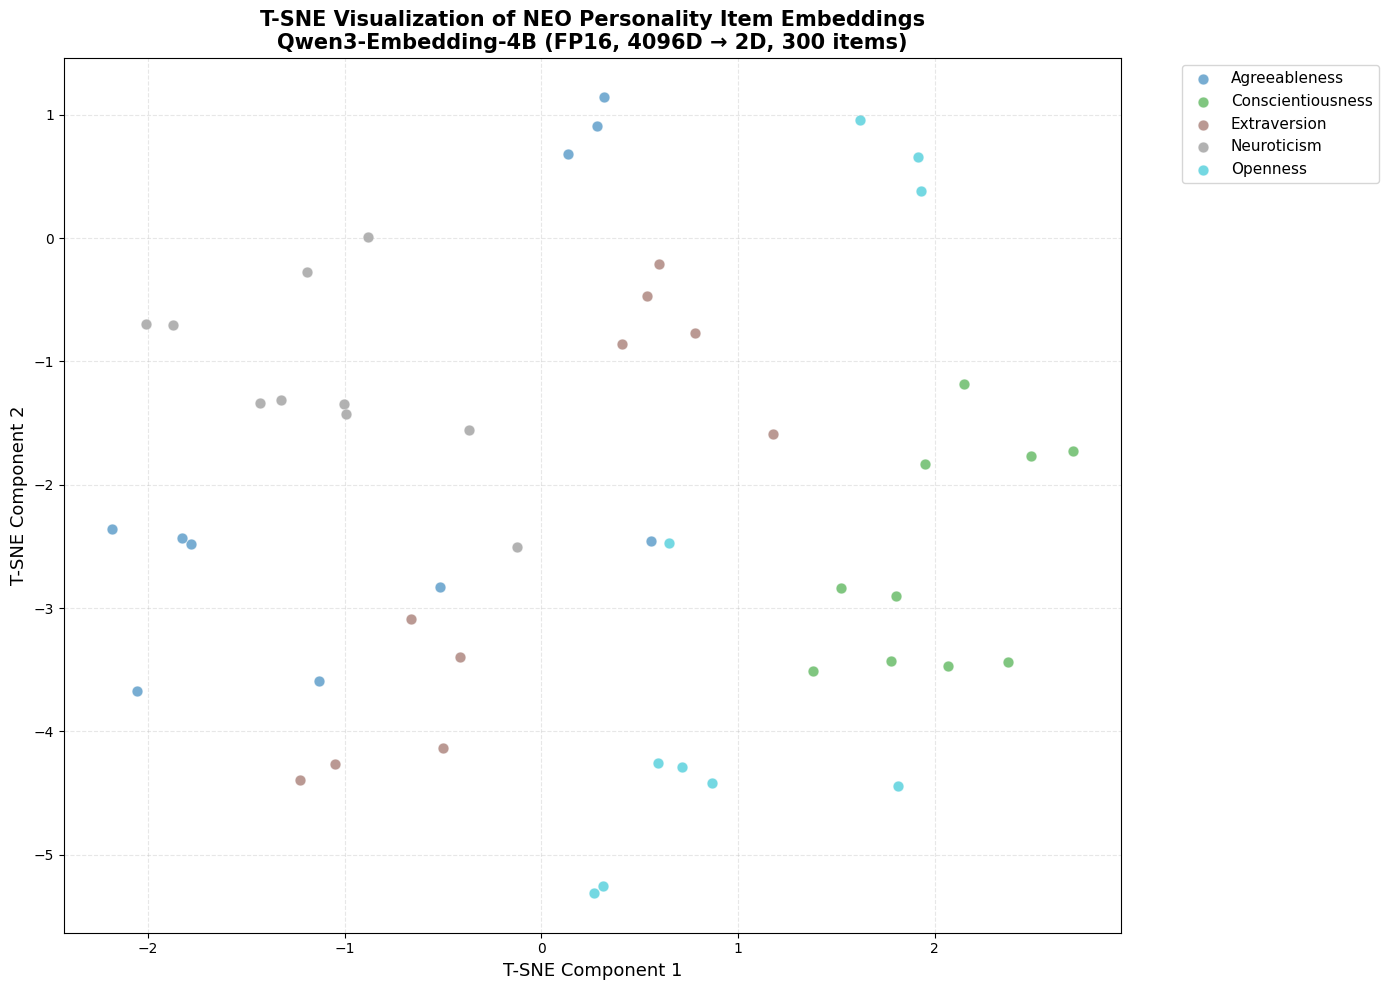


✓ Visualization complete!


In [14]:
# Create the T-SNE scatter plot
print("Creating visualization...")

# Create a color map for the personality factors
import matplotlib.cm as cm
colors_map = cm.get_cmap('tab10', len(unique_factors))
factor_to_color = {factor: colors_map(i) for i, factor in enumerate(unique_factors)}

# Create figure
plt.figure(figsize=(14, 10))

# Plot each factor with a different color
for factor in unique_factors:
    # Get indices for this factor
    indices = [i for i, f in enumerate(factors) if f == factor]
    
    # Plot points for this factor
    plt.scatter(
        embeddings_2d[indices, 0],
        embeddings_2d[indices, 1],
        c=[factor_to_color[factor]],
        label=factor,
        alpha=0.6,
        s=60,
        edgecolors='white',
        linewidth=0.5
    )

plt.xlabel('T-SNE Component 1', fontsize=13)
plt.ylabel('T-SNE Component 2', fontsize=13)
plt.title(
    f'T-SNE Visualization of NEO Personality Item Embeddings\n'
    f'Qwen3-Embedding-4B (FP16, {embeddings.shape[1]}D → 2D, 300 items)',
    fontsize=15,
    fontweight='bold'
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")

## Analyze Nearest Neighbors

In [15]:
# Explore nearest neighbors in 2D space
print("Finding nearest neighbors in T-SNE embedding space...")

# Pick a sample item to analyze
sample_idx = 0
sample_item = items[sample_idx]
sample_factor = factors[sample_idx]

print(f"\nSample item #{sample_idx}:")
print(f"  Factor: {sample_factor}")
print(f"  Text: {sample_item}")

# Calculate distances to all other items in 2D space
from scipy.spatial.distance import cdist
distances = cdist([embeddings_2d[sample_idx]], embeddings_2d)[0]

# Find 5 nearest neighbors (excluding itself)
nearest_indices = np.argsort(distances)[1:6]

print(f"\n5 Nearest neighbors in T-SNE 2D space:")
for rank, idx in enumerate(nearest_indices, 1):
    print(f"  {rank}. [{factors[idx]}] {items[idx]}")
    print(f"      Distance: {distances[idx]:.3f}")

Finding nearest neighbors in T-SNE embedding space...

Sample item #0:
  Factor: Extraversion
  Text: I am the life of the party.

5 Nearest neighbors in T-SNE 2D space:
  1. [Extraversion] I start conversations.
      Distance: 0.565
  2. [Extraversion] I don't mind being the center of attention.
      Distance: 0.745
  3. [Extraversion] I talk to a lot of different people at parties.
      Distance: 0.772
  4. [Agreeableness] I am interested in people.
      Distance: 0.834
  5. [Extraversion] I feel comfortable around people.
      Distance: 1.059


In [16]:
# Analyze nearest neighbors in the ORIGINAL high-dimensional space
print("Finding nearest neighbors in original embedding space (not T-SNE)...")

# Calculate cosine similarities in original space
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between sample and all items
similarities = cosine_similarity([embeddings[sample_idx]], embeddings)[0]

# Find 5 most similar items (excluding itself)
most_similar_indices = np.argsort(similarities)[::-1][1:6]

print(f"\nSample item #{sample_idx}:")
print(f"  Factor: {sample_factor}")
print(f"  Text: {sample_item}")
print(f"\n5 Most similar items (by cosine similarity in {embeddings.shape[1]}D space):")
for rank, idx in enumerate(most_similar_indices, 1):
    print(f"  {rank}. [{factors[idx]}] {items[idx]}")
    print(f"      Similarity: {similarities[idx]:.4f}")

Finding nearest neighbors in original embedding space (not T-SNE)...

Sample item #0:
  Factor: Extraversion
  Text: I am the life of the party.

5 Most similar items (by cosine similarity in 4096D space):
  1. [Extraversion] I start conversations.
      Similarity: 0.6744
  2. [Extraversion] I don't mind being the center of attention.
      Similarity: 0.6733
  3. [Conscientiousness] I make a mess of things.
      Similarity: 0.6714
  4. [Extraversion] I talk to a lot of different people at parties.
      Similarity: 0.6644
  5. [Extraversion] I feel comfortable around people.
      Similarity: 0.6577


## Model Comparison Notes

**Qwen3-Embedding-4B vs DistilBERT:**

| Feature | DistilBERT | Qwen3-Embedding-4B |
|---------|------------|--------------------|
| Parameters | 66M | 4B (60× larger) |
| Embedding Dimension | 768 | 1024 or higher |
| Languages | English-focused | 100+ languages |
| Training | General BERT distillation | Embedding-specialized |
| MTEB Ranking | Mid-tier | Top-tier (#1 multilingual) |
| Memory (FP16) | ~250 MB | ~8 GB |
| Code Complexity | High (manual tokenization) | Low (sentence-transformers) |

**Expected Improvements:**
- Better semantic clustering of personality items
- More coherent T-SNE visualization
- Higher correlation with observed item correlations
- Better handling of nuanced psychological language